<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/Matrix_factorization1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
path ='/content/drive/MyDrive/olist_project'
#path = '/content/drive/MyDrive/AdvancedBA/Olie_data/archive' #adust this one to yours
customers = pd.read_csv(path +'/olist_customers_dataset.csv')
reviews = pd.read_csv(path+'/olist_order_reviews_dataset.csv')
#geolocation = pd.read_csv(path+'/olist_geolocation_dataset.csv')
items = pd.read_csv(path + '/olist_order_items_dataset.csv')
#payments  = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders= pd.read_csv(path + '/olist_orders_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')
#sellers =pd.read_csv(path + '/olist_sellers_dataset.csv')
#category =  pd.read_csv(path + '/product_category_name_translation.csv')

## Merging only relevant datasets

In [ ]:

merged_df = pd.merge(orders,customers,on='customer_id')
merged_df = pd.merge(merged_df,reviews,on='order_id')
#merged_df = pd.merge(merged_df,payments,on='order_id')
merged_df = pd.merge(merged_df,items,on='order_id')
merged_df = pd.merge(merged_df,products,on='product_id')
#merged_df = pd.merge(merged_df,sellers,on='seller_id')
#merged_df = pd.merge(merged_df, product_category,on ='product_category_name')
merged_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0


In [ ]:
merged_df.shape

(113322, 32)

In [ ]:
ratings_df = merged_df[['customer_unique_id','product_id','review_score']]
ratings_df

,customer_unique_id,product_id,review_score
0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4
1,3a51803cc0d012c3b5dc8b7528cb05f7,87285b34884572647811a353c7ac498a,4
2,ef0996a1a279c26e7ecbd737be23d235,87285b34884572647811a353c7ac498a,5
3,e781fdcc107d13d865fc7698711cc572,87285b34884572647811a353c7ac498a,3
4,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,4
...,...,...,...
113317,fb9310710003399b031add3e55f34719,0df37da38a30a713453b03053d60d3f7,4
113318,fb9310710003399b031add3e55f34719,0df37da38a30a713453b03053d60d3f7,4
113319,a49e8e11e850592fe685ae3c64b40eca,3d2c44374ee42b3003a470f3e937a2ea,1
113320,6359f309b166b0196dbf7ad2ac62bb5a,ac35486adb7b02598c182c2ff2e05254,5


In [ ]:
ratings_df.isnull().sum()


customer_unique_id    0
product_id            0
review_score          0
dtype: int64

In [ ]:
ratings_df.describe()

,review_score
count,113322.000000
mean,4.015469
std,1.400166
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Filtering data

In [ ]:
min_product_ratings = 2 #a product was rated at least 
min_user_ratings =  2 #a user rated products at least


ratings_flrd_df = ratings_df.groupby("product_id").filter(lambda x: x['product_id'].count() >= min_product_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("customer_unique_id").filter(lambda x: x['customer_unique_id'].count() >= min_user_ratings)



"{0} products deleted; all products are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.product_id.value_counts()) - len(ratings_flrd_df.product_id.value_counts())\
        ,min_product_ratings,ratings_df.shape, ratings_flrd_df.shape )

'25479 products deleted; all products are now rated at least: 2 times. Old dimensions: (113322, 3); New dimensions: (25935, 3)'

In [ ]:
ratings_flrd_df

,customer_unique_id,product_id,review_score
0,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,4
14,3edcab192482e9871c17b34cf98c3996,595fac2a385ac33a80bd5114aec74eb8,5
28,958ac7760e5484df1496ba5833ab6117,595fac2a385ac33a80bd5114aec74eb8,5
29,958ac7760e5484df1496ba5833ab6117,595fac2a385ac33a80bd5114aec74eb8,5
30,60a1e88691ef46c62b52fb2b994d7675,595fac2a385ac33a80bd5114aec74eb8,2
...,...,...,...
113304,dc9ccd8be2d922f8583d97933b06c5f4,af16005fca813272caf59c432153949e,1
113305,dc9ccd8be2d922f8583d97933b06c5f4,af16005fca813272caf59c432153949e,1
113306,dc9ccd8be2d922f8583d97933b06c5f4,af16005fca813272caf59c432153949e,1
113317,fb9310710003399b031add3e55f34719,0df37da38a30a713453b03053d60d3f7,4


### Matrix factorization

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 261kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617546 sha256=e9a1b398ff39b97c82977818292b151e31963bb596852ae026d0d8c80d2c210a
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from collections import defaultdict 


import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF

np.random.seed(42)

In [ ]:
reader = Reader(rating_scale=(1.0, 5.0))
data_surprise = Dataset.load_from_df(ratings_flrd_df, reader)
data_train_surprise = data_surprise.build_full_trainset()
data_test_surprise = data_train_surprise.build_anti_testset()

In [ ]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm



In [ ]:
rmse_svd = rmse_vs_factors(SVD,data_surprise)

In [16]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "b")
  print(np.argmin(rmse))

99


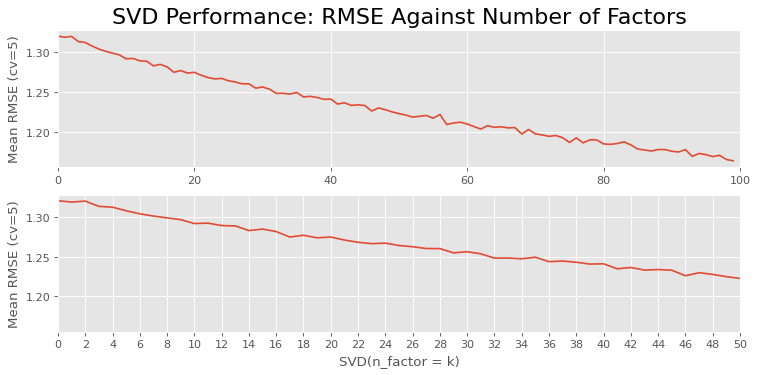

In [17]:
plot_rmse(rmse_svd,"SVD")

In [ ]:
algo_SVD = SVD(n_factors = 99)
algo_SVD.fit(data_train_surprise)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = data_train_surprise.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:5]

## Matrix factorization using product category name

In [ ]:
from collections import defaultdict 


import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF

np.random.seed(42)

In [ ]:
ratings_matrix

,housewares,baby,cool_stuff,sports_leisure,toys,furniture_decor,perfumery,health_beauty,music,pet_shop,...,dvds_blu_ray,flowers,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,cine_photo,diapers_and_hygiene,books_imported,la_cuisine
7c396fd4830fd04220f754e42b4e5bff,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3a51803cc0d012c3b5dc8b7528cb05f7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ef0996a1a279c26e7ecbd737be23d235,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e781fdcc107d13d865fc7698711cc572,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7a1de9bde89aedca8c5fbad489c5571c,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96328ac15f58fbb232fe14b182103382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
9b8844d7cceb1277e6508cce966e4a09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6c861f46d09c560422f6ba6b33c017fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6968d41eb700f1ea39424e04b854bf7e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [ ]:
customer_ids, product_ids, ratings = [], [], []

for customer_id, row in ratings_matrix.iterrows():
    for product_id in ratings_matrix.columns:
        rating = row[product_id] 
        if not np.isnan(rating): 
            customer_ids.append(customer_id)
            product_ids.append(product_id)
            ratings.append(rating)
ratings_df = pd.DataFrame({'customer_id':customer_ids, 'product_id':product_ids, 'rating':ratings})
ratings_df = ratings_df[['customer_id', 'product_id', 'rating']] 
ratings_df

,customer_id,product_id,rating
0,7c396fd4830fd04220f754e42b4e5bff,housewares,4
1,7c396fd4830fd04220f754e42b4e5bff,baby,5
2,3a51803cc0d012c3b5dc8b7528cb05f7,housewares,4
3,ef0996a1a279c26e7ecbd737be23d235,housewares,5
4,e781fdcc107d13d865fc7698711cc572,housewares,3
...,...,...,...
96442,96328ac15f58fbb232fe14b182103382,la_cuisine,4
96443,9b8844d7cceb1277e6508cce966e4a09,la_cuisine,5
96444,6c861f46d09c560422f6ba6b33c017fe,la_cuisine,5
96445,6968d41eb700f1ea39424e04b854bf7e,la_cuisine,5


In [ ]:
ratings_df.describe()

,rating
count,96447.000000
mean,4.083963
std,1.347168
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Filtering data

In [ ]:
min_product_ratings = 2 #a product was rated at least 
min_user_ratings =  2 #a user rated products at least


ratings_flrd_df = ratings_df.groupby("product_id").filter(lambda x: x['product_id'].count() >= min_product_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("customer_id").filter(lambda x: x['customer_id'].count() >= min_user_ratings)



"{0} products deleted; all products categories are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.product_id.value_counts()) - len(ratings_flrd_df.product_id.value_counts())\
        ,min_product_ratings,ratings_df.shape, ratings_flrd_df.shape )

'3 products deleted; all products categories are now rated at least: 2 times. Old dimensions: (96447, 3); New dimensions: (4571, 3)'

In [ ]:
ratings_flrd_df

,customer_id,product_id,rating
0,7c396fd4830fd04220f754e42b4e5bff,housewares,4
1,7c396fd4830fd04220f754e42b4e5bff,baby,5
5,7a1de9bde89aedca8c5fbad489c5571c,housewares,1
6,7a1de9bde89aedca8c5fbad489c5571c,construction_tools_construction,5
49,94bd5dee83e9590368179f4ab026b4f4,housewares,4
...,...,...,...
94398,a914b2be4782207abc6758095ec9e8aa,cine_photo,5
95486,ab93bfed86e2417198d66cf58945442e,costruction_tools_garden,5
95487,ab93bfed86e2417198d66cf58945442e,books_technical,5
95527,9082dcf13bb5feb0e686d709eb35d02c,costruction_tools_garden,4


In [ ]:
reader = Reader(rating_scale=(1.0, 5.0))
data_surprise = Dataset.load_from_df(ratings_flrd_df, reader)
data_train_surprise = data_surprise.build_full_trainset()
data_test_surprise = data_train_surprise.build_anti_testset()

In [ ]:
def rmse_vs_factors(algorithm, data):
  """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1)
  100 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  """
  
  rmse_algorithm = []
  
  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

rmse_svd = rmse_vs_factors(SVD,data_surprise)

In [ ]:
rmse_svd = rmse_vs_factors(SVD,data_surprise)

In [ ]:
def plot_rmse(rmse, algorithm):
  """Returns: sub plots (2x1) of rmse against number of factors. 
     Vertical line in the second subplot identifies the arg for minimum RMSE
    
     Arg: i.) rmse = list of mean RMSE returned by rmse_vs_factors(), ii.) algorithm = STRING! of algo 
  """
  
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "b")
  print(np.argmin(rmse))

45


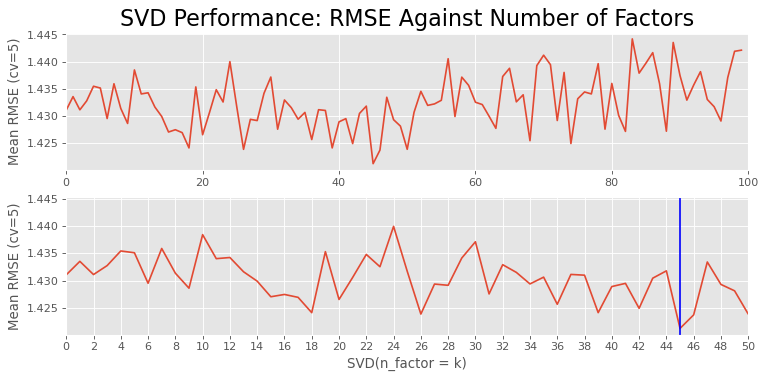

In [ ]:
plot_rmse(rmse_svd,"SVD")

### the best n_factor is 45.

In [ ]:
algo_SVD = SVD(n_factors = 45)
algo_SVD.fit(data_train_surprise)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = data_train_surprise.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:5]

[Prediction(uid='7c396fd4830fd04220f754e42b4e5bff', iid='construction_tools_construction', r_ui=3.8612994968278276, est=3.686100358123784, details={'was_impossible': False}),
 Prediction(uid='7c396fd4830fd04220f754e42b4e5bff', iid='stationery', r_ui=3.8612994968278276, est=4.349660921307222, details={'was_impossible': False}),
 Prediction(uid='7c396fd4830fd04220f754e42b4e5bff', iid='computers_accessories', r_ui=3.8612994968278276, est=4.134520749155383, details={'was_impossible': False}),
 Prediction(uid='7c396fd4830fd04220f754e42b4e5bff', iid='bed_bath_table', r_ui=3.8612994968278276, est=4.027745410475921, details={'was_impossible': False}),
 Prediction(uid='7c396fd4830fd04220f754e42b4e5bff', iid='sports_leisure', r_ui=3.8612994968278276, est=4.055719889427228, details={'was_impossible': False})]

## Splitting into the train & test set

In [ ]:
ratings_matrix

,housewares,baby,cool_stuff,sports_leisure,toys,furniture_decor,perfumery,health_beauty,music,pet_shop,...,dvds_blu_ray,flowers,cds_dvds_musicals,security_and_services,tablets_printing_image,furniture_bedroom,cine_photo,diapers_and_hygiene,books_imported,la_cuisine
7c396fd4830fd04220f754e42b4e5bff,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3a51803cc0d012c3b5dc8b7528cb05f7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ef0996a1a279c26e7ecbd737be23d235,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e781fdcc107d13d865fc7698711cc572,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7a1de9bde89aedca8c5fbad489c5571c,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96328ac15f58fbb232fe14b182103382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
9b8844d7cceb1277e6508cce966e4a09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6c861f46d09c560422f6ba6b33c017fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6968d41eb700f1ea39424e04b854bf7e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [ ]:
customer_ids, product_ids, ratings = [], [], []

for customer_id, row in ratings_matrix.iterrows():
    for product_id in ratings_matrix.columns:
        rating = row[product_id] # rating given by a perticular user to perticular product
        if not np.isnan(rating): # if there is a rating
            customer_ids.append(customer_id)
            product_ids.append(product_id)
            ratings.append(rating)
ratings_df = pd.DataFrame({'customer_id':customer_ids, 'product_id':product_ids, 'rating':ratings})
ratings_df = ratings_df[['customer_id', 'product_id', 'rating']] # correct order
ratings_df

,customer_id,product_id,rating
0,7c396fd4830fd04220f754e42b4e5bff,housewares,4
1,7c396fd4830fd04220f754e42b4e5bff,baby,5
2,3a51803cc0d012c3b5dc8b7528cb05f7,housewares,4
3,ef0996a1a279c26e7ecbd737be23d235,housewares,5
4,e781fdcc107d13d865fc7698711cc572,housewares,3
...,...,...,...
96442,96328ac15f58fbb232fe14b182103382,la_cuisine,4
96443,9b8844d7cceb1277e6508cce966e4a09,la_cuisine,5
96444,6c861f46d09c560422f6ba6b33c017fe,la_cuisine,5
96445,6968d41eb700f1ea39424e04b854bf7e,la_cuisine,5


In [ ]:
min_product_ratings = 2 #a product has was rated at least 
min_user_ratings =  2 #a user rated movies at least


ratings_flrd_df = ratings_df.groupby("product_id").filter(lambda x: x['product_id'].count() >= min_product_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("customer_id").filter(lambda x: x['customer_id'].count() >= min_user_ratings)



"{0} products deleted; all products categories are now rated at least: {1} times. Old dimensions: {2}; New dimensions: {3}"\
.format(len(ratings_df.product_id.value_counts()) - len(ratings_flrd_df.product_id.value_counts())\
        ,min_product_ratings,ratings_df.shape, ratings_flrd_df.shape )

'3 products deleted; all products categories are now rated at least: 2 times. Old dimensions: (96447, 3); New dimensions: (4571, 3)'

In [ ]:
ratings_flrd_df.shape

(4571, 3)

In [ ]:
ratings_flrd_df

,customer_id,product_id,rating
0,7c396fd4830fd04220f754e42b4e5bff,housewares,4
1,7c396fd4830fd04220f754e42b4e5bff,baby,5
5,7a1de9bde89aedca8c5fbad489c5571c,housewares,1
6,7a1de9bde89aedca8c5fbad489c5571c,construction_tools_construction,5
49,94bd5dee83e9590368179f4ab026b4f4,housewares,4
...,...,...,...
94398,a914b2be4782207abc6758095ec9e8aa,cine_photo,5
95486,ab93bfed86e2417198d66cf58945442e,costruction_tools_garden,5
95487,ab93bfed86e2417198d66cf58945442e,books_technical,5
95527,9082dcf13bb5feb0e686d709eb35d02c,costruction_tools_garden,4


In [ ]:
train_ind, test_ind = [], []
#
for product_id in ratings_flrd_df['product_id'].unique():
    rows = ratings_flrd_df[ratings_flrd_df['product_id'] == product_id]
    ind = rows.index[:2].values.tolist()
    train_ind += ind
#
c = 0.7
b = len(train_ind) / len(ratings_flrd_df)
a = (c - b) / (1 - b)
#print(a)
#
all_ind = set(range(len(ratings_flrd_df)))
not_used = list(all_ind - set(train_ind))
not_done = True
np.random.seed(42)
while not_done:
    np.random.shuffle(not_used)
    train_ind_ = train_ind + not_used[:int(a * len(not_used))]
    df_train = ratings_flrd_df.loc[train_ind_]
    print(ratings_flrd_df.nunique()['product_id'], df_train.nunique()['product_id'])
    print(ratings_flrd_df.nunique()['customer_id'], df_train.nunique()['customer_id'])
    if ratings_flrd_df.nunique()['product_id'] == df_train.nunique()['product_id'] and ratings_flrd_df.nunique()['customer_id'] == df_train.nunique()['customer_id']:
        not_done = False
        train_ind = train_ind_
#
test_ind = list(all_ind - set(train_ind))
#
train_ind = sorted(train_ind)
test_ind = sorted(test_ind)
#print(len(train_ind)/len(all_ind))
#print(len(test_ind)/len(all_ind))
#
np.savetxt('data_train.csv', train_ind, fmt="%d")# saving the train data
np.savetxt('data_test.csv', test_ind, fmt="%d")# saving the test data

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([3619, 1512, 4006, 3502, 2422,\n            ...\n            1647, 3765,  730, 3085, 3026],\n           dtype='int64', length=2797). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"